#### Import

In [3]:
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from analyze_snar.extraction import extract_dataframe, add_kinetic_data, add_solvent_descriptors
from analyze_snar.plotting import interactive_plot
from predict_snar.descriptors import RFPCalculator
from predict_snar.smiles import ReactionSmilesProcessor
from sklearn.preprocessing import OrdinalEncoder
from rdkit import Chem
from rdkit.Chem import AllChem

fcntl not avaiable on Windows.
resource not available on Windows.


Plotting settings

In [4]:
%matplotlib inline
plt.style.use("default")
figsize_default = np.array(matplotlib.rc_params()["figure.figsize"])

#### Load data. Add kinetic data

No clustering correction

In [5]:
df = extract_dataframe("2019-12-15/db", or_lg_correction=True)
n_reactions = len(df)
df = df.drop_duplicates(["reaction_smiles", "solvent", "temperature"])
n_duplicates = n_reactions - len(df)
print("Number of duplicated reactions removed:", n_duplicates)
df = add_kinetic_data(df, "../prepare_kinetic_data/kinetic_data.csv")
df = add_solvent_descriptors(df, "../solvents/solvents.csv")

Number of duplicated reactions removed: 23


Cluster nucleophile

In [6]:
df_nu = extract_dataframe("2019-12-15/db", cluster_nu=True, or_lg_correction=True)
df_nu = df_nu.drop_duplicates(["reaction_smiles", "solvent", "temperature"])
df_nu = add_kinetic_data(df_nu, "../prepare_kinetic_data/kinetic_data.csv")
df_nu = add_solvent_descriptors(df_nu, "../solvents/solvents.csv")

Cluster nucleophile and TS

In [7]:
df_ts = extract_dataframe("2019-12-15/db", cluster_nu=True, cluster_ts=True, or_lg_correction=True)
df_ts = df_ts.drop_duplicates(["reaction_smiles", "solvent", "temperature"])
df_ts = add_kinetic_data(df_ts, "../prepare_kinetic_data/kinetic_data.csv")
df_ts = add_solvent_descriptors(df_ts, "../solvents/solvents.csv")

Add the different activation energies to dataframe

In [8]:
df.rename(columns={"activation_energy": "activation_energy_none",
                   "activation_energy_qh_grimme": "activation_energy_qh_grimme_none",
                   "activation_energy_qh_truhlar": "activation_energy_qh_truhlar_none"}, inplace=True)

In [9]:
df["activation_energy_nu"] = df_nu["activation_energy"]
df["activation_energy_qh_grimme_nu"] = df_nu["activation_energy_qh_grimme"]
df["activation_energy_qh_truhlar_nu"] = df_nu["activation_energy_qh_truhlar"]
df["activation_energy_ts"] = df_ts["activation_energy"]
df["activation_energy_qh_grimme_ts"] = df_ts["activation_energy_qh_grimme"]
df["activation_energy_qh_truhlar_ts"] = df_ts["activation_energy_qh_truhlar"]

In [10]:
df["reaction_enthalpy"] = df_ts["reaction_enthalpy"]
df["activation_enthalpy"] = df_ts["activation_enthalpy"]

#### Investigate missing data

In [11]:
df.columns[df.isna().any()]

Index(['exp_activation_energy', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5'], dtype='object')

In [12]:
df[df.isna().any(axis=1)]

,reaction_smiles,reaction_smiles_orig,v_av_central_atom,v_av_nu_atom,reaction_energy,reaction_enthalpy,reaction_energy_qh_grimme,reaction_energy_qh_truhlar,activation_energy_none,activation_enthalpy,...,pc_2,pc_3,pc_4,pc_5,activation_energy_nu,activation_energy_qh_grimme_nu,activation_energy_qh_truhlar_nu,activation_energy_ts,activation_energy_qh_grimme_ts,activation_energy_qh_truhlar_ts
201,O=[N+]([O-])c1ccc(F)cc1.[N-]=[N+]=[N-]>>[N-]=[...,C1=CC(=CC=C1[N+](=O)[O-])F.[N-]=[N+]=[N-]>>[N-...,12.1,-129.2,8.209084,5.823293,8.424947,8.396709,14.697602,4.889629,...,NaN,NaN,NaN,NaN,14.697602,14.708269,14.545744,14.697602,14.708269,14.545744
322,N#Cc1cc(C(F)(F)F)ccc1Cl.CCCCN>>CCCCNc1ccc(C(F)...,FC(F)(F)c1ccc(Cl)c(c1)C#N.CCCCN>>CCCCNc1ccc(cc...,16.2,-13.3,-16.190873,-18.678320,-15.238313,-14.979152,24.766734,14.225202,...,-4.74864,-3.28165,-0.304043,4.2989,24.766734,26.227576,26.665578,24.766734,26.227576,26.665578


Drops:
* 1 entry that corresponds to erroneous submitted reaction smiles
* 1 with TMS as solvent (no PCA descriptors for TMS)

In [13]:
print(f"Rows with missing data: {sum(df.isna().any(axis=1))}")
df.dropna(inplace=True)

Rows with missing data: 2


#### Investigate low-barrier reactions

Remove 4 rows where TS calculations failed, leading to very low or high activation energies.
Remove 2 rows with C nucleophiles which are not handled properly

In [14]:
before = df.shape[0]
df = df[df["activation_energy_none"] >= 5]
df.drop(df[df["reaction_smiles"] == "COc1cc([N+](=O)[O-])ccn1.C1COCCN1>>O=[N+]([O-])c1ccnc(N2CCOCC2)c1.CO"].index, inplace=True)
df.drop(df[(df["reaction_smiles"] == "COc1c(S(=O)(=O)C(F)(F)F)cc([N+](=O)[O-])cc1S(=O)(=O)C(F)(F)F.Nc1ccccc1>>O=[N+]([O-])c1cc(S(=O)(=O)C(F)(F)F)c(Nc2ccccc2)c(S(=O)(=O)C(F)(F)F)c1.CO")
  & (df["solvent"] == "C(C)#N")].index, inplace=True)
df.drop(df[df["nu_symbol"] == "C"].index, inplace=True)
print("Removed rows:", before - df.shape[0])

Removed rows: 6


Drop reaction that was omitted previously due to bug

In [15]:
df.drop(474, inplace=True)

In [16]:
print("Number of rows:", df.shape[0])

Number of rows: 443


Reindex the dataframe 

In [17]:
df.reset_index(drop=True, inplace=True)

#### Investigate target

In [24]:
ae_max = df["exp_activation_energy"].max()
ae_min = df["exp_activation_energy"].min()
ae_mean = df["exp_activation_energy"].mean()
print(f"Activation energy range: {ae_min:.2f}-{ae_max:.2f}")
print(f"Mean activation energy: {ae_mean:.2f}")

Activation energy range: 12.53-42.44
Mean activation energy: 21.38


Text(0, 0.5, 'Number of reactions')

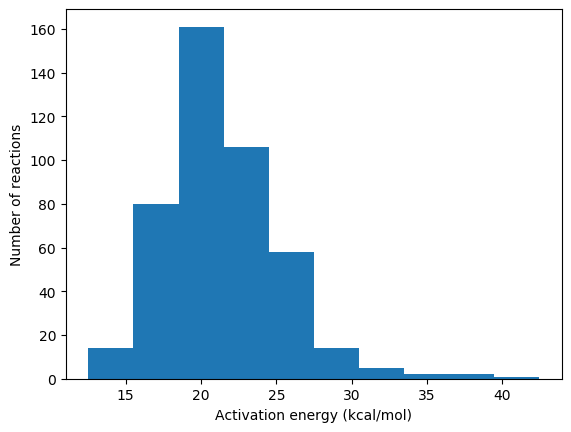

In [25]:
df["exp_activation_energy"].hist(grid=False)
plt.xlabel("Activation energy (kcal/mol)")
plt.ylabel("Number of reactions")

Print deviating activation energies

In [26]:
df[abs(df["activation_energy_none"] - df["exp_activation_energy"]) > 10][["reaction_smiles", "activation_energy_none", "exp_activation_energy"]]

,reaction_smiles,activation_energy_none,exp_activation_energy
28,O=[N+]([O-])c1ccc(Cl)c([N+](=O)[O-])c1.Nc1ccc(...,7.666805,18.35
29,O=[N+]([O-])c1ccc(Cl)c([N+](=O)[O-])c1.Fc1ccc(...,9.521914,19.79
31,O=[N+]([O-])c1ccc(Cl)c([N+](=O)[O-])c1.COc1ccc...,8.002731,18.81
36,O=[N+]([O-])c1ccc(Cl)c([N+](=O)[O-])c1.Nc1cccc...,9.244728,19.42
37,O=[N+]([O-])c1ccc(Cl)c([N+](=O)[O-])c1.[S-]c1c...,10.440245,20.49
39,O=[N+]([O-])c1ccc(Cl)c([N+](=O)[O-])c1.[S-]c1c...,10.389361,20.44
42,O=[N+]([O-])c1ccc(Cl)c([N+](=O)[O-])c1.CC(=O)c...,9.876028,20.04
66,Clc1ccccc1.C[O-]>>COc1ccccc1.[Cl-],30.027717,42.44
132,O=[N+]([O-])c1ccc(Oc2ccccc2)c([N+](=O)[O-])c1....,10.364870,21.72
138,O=[N+]([O-])c1cccc(Oc2ccc([N+](=O)[O-])cc2[N+]...,9.567143,20.47


In [27]:
df.columns

Index(['reaction_smiles', 'reaction_smiles_orig', 'v_av_central_atom',
       'v_av_nu_atom', 'reaction_energy', 'reaction_enthalpy',
       'reaction_energy_qh_grimme', 'reaction_energy_qh_truhlar',
       'activation_energy_none', 'activation_enthalpy',
       'activation_energy_qh_grimme_none', 'activation_energy_qh_truhlar_none',
       'sasa_nu', 'sasa_central', 'sasa_ratio_nu', 'sasa_ratio_central',
       'epn_central', 'epn_nu', 'epn_lg', 'epn_central_ts', 'epn_nu_ts',
       'epn_lg_ts', 'nu_charge', 'nu_charge_ts', 'central_charge',
       'central_charge_ts', 'lg_charge', 'lg_charge_ts', 'nu_formed',
       'lg_broken', 'omega', 'n', 'local_electrophilicity_center',
       'local_nucleophilicity_nu', 'is_av', 'es_av', 'concerted', 'rds',
       'flat_pes', 'p_int_central', 'p_int_nu', 'p_int_area_central',
       'p_int_area_nu', 'bo_diff_nu', 'bo_diff_lg', 'bo_sub_lg', 'bo_nu_ts',
       'bo_lg_ts', 'bo_prod_nu', 'nu_symbol', 'lg_symbol', 'solvent',
       'inchikey_substra

N    306
O    117
S     20
Name: nu_symbol, dtype: int64


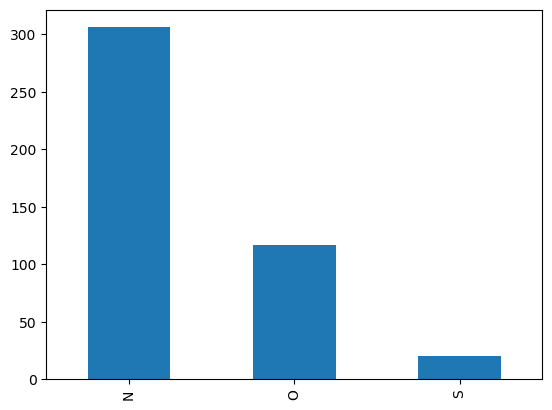

In [28]:
nu_counts = df["nu_symbol"].value_counts()
print(nu_counts)
nu_counts.plot.bar()

Cl    196
O     108
F      92
Br     29
I      12
N       6
Name: lg_symbol, dtype: int64


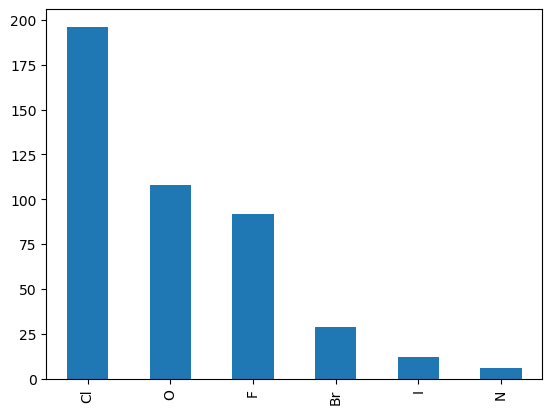

In [29]:
lg_counts = df["lg_symbol"].value_counts()
print(lg_counts)
lg_counts.plot.bar()

In [30]:
df["lg_symbol"]

0      Cl
1      Cl
2      Cl
3      Cl
4      Cl
       ..
438     O
439    Cl
440     O
441     O
442     O
Name: lg_symbol, Length: 443, dtype: object

Text(50.722222222222214, 0.5, 'Leaving atom')

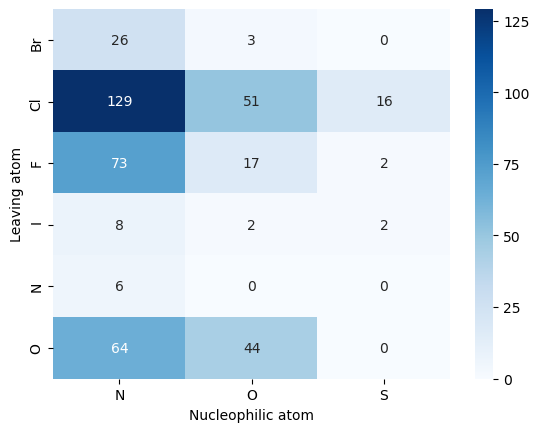

In [31]:
sns.heatmap(pd.crosstab(df["lg_symbol"], df["nu_symbol"]), cmap="Blues", annot=True, fmt="d")
plt.xlabel("Nucleophilic atom")
plt.ylabel("Leaving atom")

### Construct one-hot-encoded features

In [38]:
from sklearn.preprocessing import OneHotEncoder

In [39]:
enc = OneHotEncoder()

In [40]:
ohe_features = enc.fit_transform(df[["inchikey_nu", "inchikey_substrate", "inchikey_product", "inchikey_lg", "solvent"]])
X_ohe = pd.DataFrame(ohe_features.toarray())
X_ohe = pd.concat([X_ohe, df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5", "temperature"]]], axis=1)

### Construct reaction fingerprints

In [41]:
X_morgan_0 = df["reaction_smiles"].apply(lambda x: RFPCalculator(x).get_morgan(radius=0, size=1024, vector_type="count"))
X_morgan_1 = df["reaction_smiles"].apply(lambda x: RFPCalculator(x).get_morgan(radius=1, size=1024, vector_type="count"))
X_morgan_2 = df["reaction_smiles"].apply(lambda x: RFPCalculator(x).get_morgan(radius=2, size=1024, vector_type="count"))
X_morgan_3 = df["reaction_smiles"].apply(lambda x: RFPCalculator(x).get_morgan(radius=3, size=1024, vector_type="count"))
X_morgan_3_bit = df["reaction_smiles"].apply(lambda x: RFPCalculator(x).get_morgan(radius=3, size=1024, vector_type="bit"))
X_morgan_3_512 = df["reaction_smiles"].apply(lambda x: RFPCalculator(x).get_morgan(radius=3, size=512, vector_type="count"))
X_morgan_3_2048 = df["reaction_smiles"].apply(lambda x: RFPCalculator(x).get_morgan(radius=3, size=2048, vector_type="count"))
X_morgan_4 = df["reaction_smiles"].apply(lambda x: RFPCalculator(x).get_morgan(radius=4, size=1024, vector_type="count"))
X_morgan_5 = df["reaction_smiles"].apply(lambda x: RFPCalculator(x).get_morgan(radius=5, size=1024, vector_type="count"))
X_morgan_6 = df["reaction_smiles"].apply(lambda x: RFPCalculator(x).get_morgan(radius=6, size=1024, vector_type="count"))

In [42]:
X_morgan_0 = pd.concat([pd.DataFrame(X_morgan_0.to_list()), df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)
X_morgan_1 = pd.concat([pd.DataFrame(X_morgan_1.to_list()), df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)
X_morgan_2 = pd.concat([pd.DataFrame(X_morgan_2.to_list()), df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)
X_morgan_3 = pd.concat([pd.DataFrame(X_morgan_3.to_list()), df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)
X_morgan_3_bit = pd.concat([pd.DataFrame(X_morgan_3_bit.to_list()), df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)
X_morgan_3_512 = pd.concat([pd.DataFrame(X_morgan_3_512.to_list()), df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)
X_morgan_3_2048 = pd.concat([pd.DataFrame(X_morgan_3_2048.to_list()), df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)
X_morgan_4 = pd.concat([pd.DataFrame(X_morgan_4.to_list()), df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)
X_morgan_5 = pd.concat([pd.DataFrame(X_morgan_5.to_list()), df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)
X_morgan_6 = pd.concat([pd.DataFrame(X_morgan_6.to_list()), df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)

In [43]:
X_bert_ft = pd.read_csv("../bert_rxnfp/bert_ft.csv", header=None)
X_bert_ft = pd.concat([X_bert_ft, df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)
X_bert_pt = pd.read_csv("../bert_rxnfp/bert_pt.csv", header=None)
X_bert_pt = pd.concat([X_bert_pt, df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)

### Construct ISIDA features from CGR

Write the reaction smiles to file

In [44]:
series = df["reaction_smiles"]
series.to_csv("to_cgr.csv", index=False, header=False)

Read the ISIDA descriptors from file and add solvent descriptors + temperature

In [45]:
X_isida_seq_6 = pd.read_csv("../cgr_isida_descriptors/isida_sequence_6.csv")
X_isida_seq_6 = pd.concat([X_isida_seq_6, df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)
X_isida_seq_8 = pd.read_csv("../cgr_isida_descriptors/isida_sequence_8.csv")
X_isida_seq_8 = pd.concat([X_isida_seq_8, df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)

In [46]:
X_isida_atom_4 = pd.read_csv("../cgr_isida_descriptors/isida_atom_4.csv")
X_isida_atom_4 = pd.concat([X_isida_atom_4, df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)
X_isida_atom_8 = pd.read_csv("../cgr_isida_descriptors/isida_atom_8.csv")
X_isida_atom_8 = pd.concat([X_isida_atom_8, df[["pc_1", "pc_2", "pc_3", "pc_4", "pc_5"]]], axis=1)

### Construct groups of reactions where only conditions differs

In [47]:
gb = df.groupby("reaction_smiles")
all_groups = {reaction_smiles: indices for reaction_smiles, indices in gb.groups.items()}
n_all = len(all_groups)
one_groups = {reaction_smiles: indices for reaction_smiles, indices in gb.groups.items() if len(indices) == 1}
n_one = len(one_groups)
many_groups = {reaction_smiles: indices for reaction_smiles, indices in gb.groups.items() if len(indices) > 1}
n_many = len(many_groups)
n_total = df.shape[0]

In [48]:
print(f"Total number of reactions: {n_total}")
print(f"Number of unique reactions: {n_all}")
print(f"Number of reactions with one condition: {n_one}")
print(f"Number of reactions with many conditions: {n_many}")
print(f"Ratio unique reactions: {n_one / n_all:.2f}")
print(f"Ratio non-unique reactions: {n_many / n_all:.2f}")

Total number of reactions: 443
Number of unique reactions: 335
Number of reactions with one condition: 272
Number of reactions with many conditions: 63
Ratio unique reactions: 0.81
Ratio non-unique reactions: 0.19


In [49]:
lens = [len(value) for value in many_groups.values()]
values, counts = np.unique(lens, return_counts=True)
print(f"{'No. rxns':>10s}{'Count':>10s}")
for value, count in zip(values, counts):
    print(f"{value:10d}{count:10d}")

  No. rxns     Count
         2        50
         3         5
         4         1
         5         1
         6         1
         8         4
         9         1


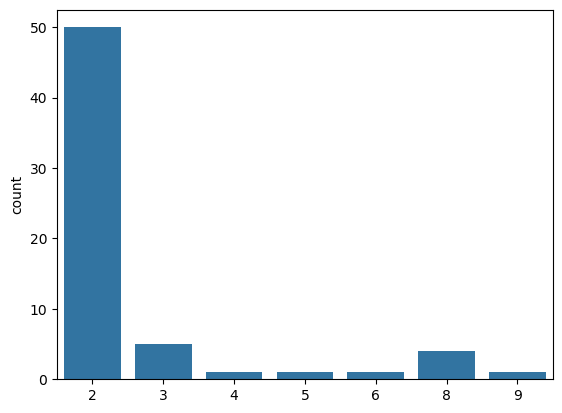

In [50]:
sns.countplot(lens, color="tab:blue")

Save groups for later cross-validation

In [51]:
group_indices = OrdinalEncoder(dtype=np.int).fit_transform(df["reaction_smiles"].values.reshape(-1, 1)).reshape(-1)

In [52]:
np.save("train_test_data/group_indices.npy", group_indices)

#### Identify reactions which lead to regioisomers

In [88]:
rsmp = rsmps[0]

In [89]:
rsmps = df["reaction_smiles"].apply(lambda x: ReactionSmilesProcessor(x))
products = [rsmp.products[0] for rsmp in rsmps]
substrate_smiles = [Chem.MolToSmiles(rsmp.substrate) for rsmp in rsmps]
nu_smiles = [Chem.MolToSmiles(rsmp.nu) for rsmp in rsmps]
nu_charges =[Chem.GetFormalCharge(rsmp.nu) for rsmp in rsmps]
chemical_formulas = [AllChem.CalcMolFormula(product) for product in products]
iso_data = {"reaction_smiles": df["reaction_smiles"],
            "solvent_smiles": df["solvent"],
            "chemical_formula": chemical_formulas,
            "substrate_smiles": substrate_smiles,
            "nu_smiles": nu_smiles,
            "temperature": df["temperature"],
            }
iso_df = pd.DataFrame(iso_data)

In [90]:
gb = iso_df[iso_df.duplicated(["chemical_formula", "substrate_smiles", "nu_smiles", "solvent_smiles", "temperature"], keep=False)].groupby(["substrate_smiles", "nu_smiles"])
groups = [list(indices) for indices in gb.groups.values()]

In [91]:
with open("train_test_data/regioisomeric_products.joblib", "wb") as file:
    joblib.dump(groups, file)

#### Group reactions in terms of substrates and nucleophiles

In [92]:
substrate_smiles = np.array(substrate_smiles)
unique_substrate_smiles, indices, counts = np.unique(substrate_smiles, return_index=True, return_counts=True)
top_indices = np.argsort(counts)[::-1]
top_mols = [Chem.MolFromSmiles(smiles) for smiles in unique_substrate_smiles[top_indices[:10]]]
top_counts = [str(count) for count in counts[top_indices[:10]]]

In [93]:
substrate_indices = OrdinalEncoder(dtype=np.int).fit_transform(substrate_smiles.reshape(-1, 1)).reshape(-1)
np.save("train_test_data/substrate_indices.npy", substrate_indices)

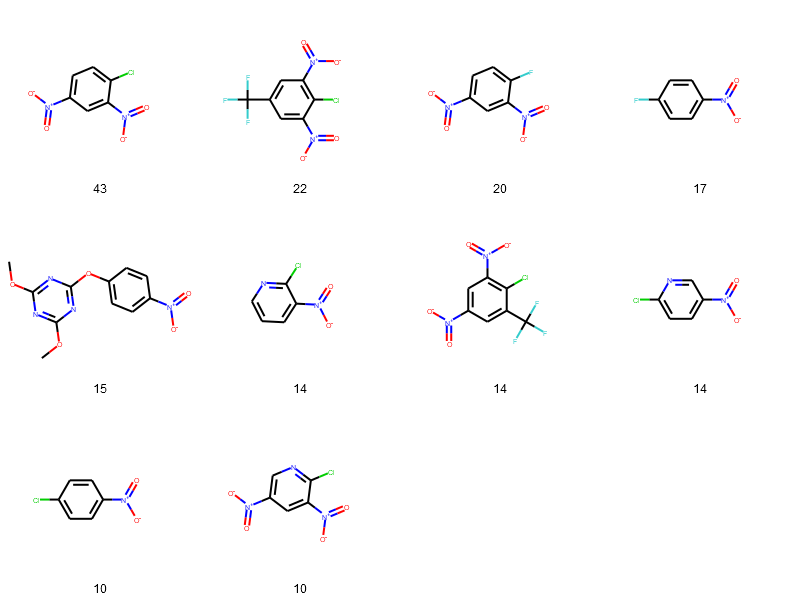

In [94]:
Chem.Draw.MolsToGridImage(top_mols, molsPerRow=4, legends=top_counts)

In [95]:
nu_smiles = np.array(nu_smiles)
unique_nu_smiles, indices, counts = np.unique(nu_smiles, return_index=True, return_counts=True)
top_indices = np.argsort(counts)[::-1]
top_mols = [Chem.MolFromSmiles(smiles) for smiles in unique_nu_smiles[top_indices[:10]]]
top_counts = [str(count) for count in counts[top_indices[:10]]]

In [96]:
nu_indices = OrdinalEncoder(dtype=np.int).fit_transform(nu_smiles.reshape(-1, 1)).reshape(-1)
np.save("train_test_data/nu_indices.npy", nu_indices)

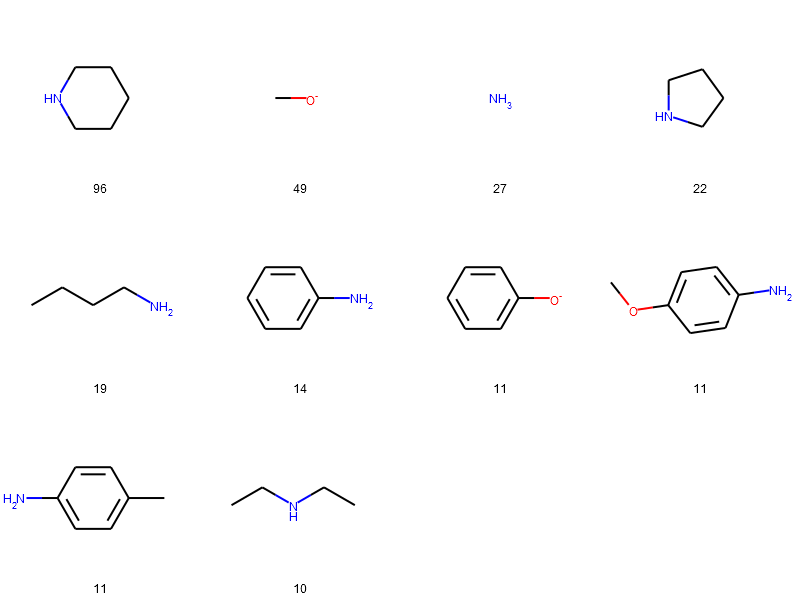

In [97]:
Chem.Draw.MolsToGridImage(top_mols, molsPerRow=4, legends=top_counts)

Investigate solvents

In [99]:
new_df = pd.DataFrame({"nu_symbol": df["nu_symbol"], "nu_charge": nu_charges, "nu_smiles": nu_smiles, "solvent": df["solvent"]})

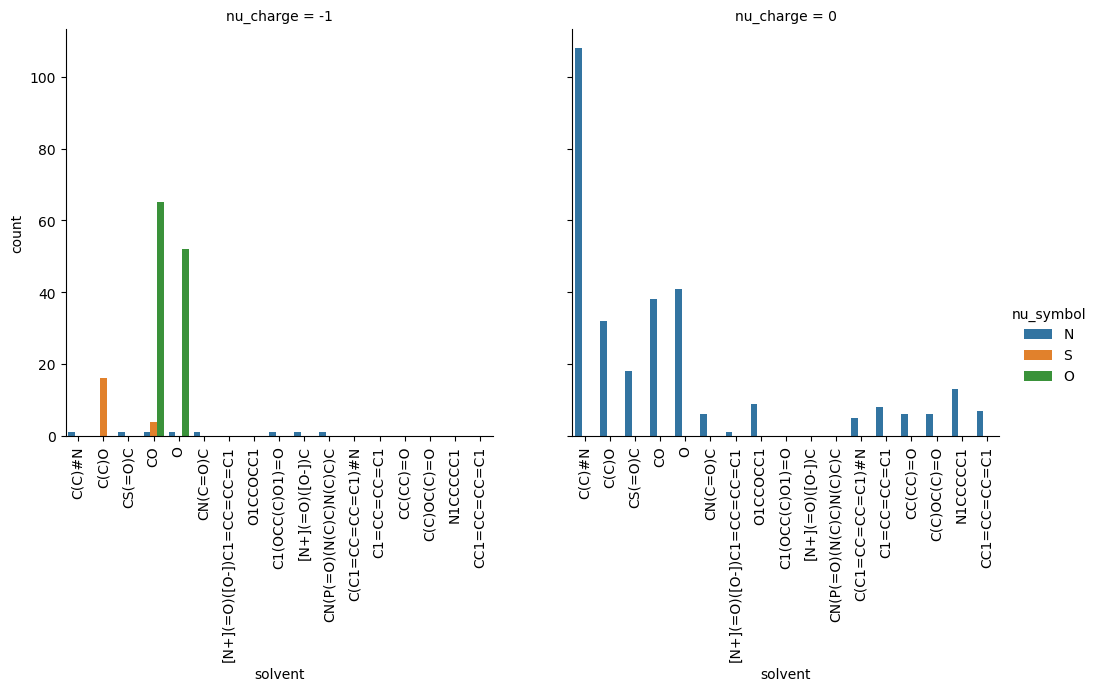

In [123]:
g = sns.catplot(x="solvent", hue="nu_symbol", col="nu_charge", data=new_df, kind="count")#height=4, aspect=.7);
g.set_xticklabels(rotation=90)
#plt.xticks(rotation=90)

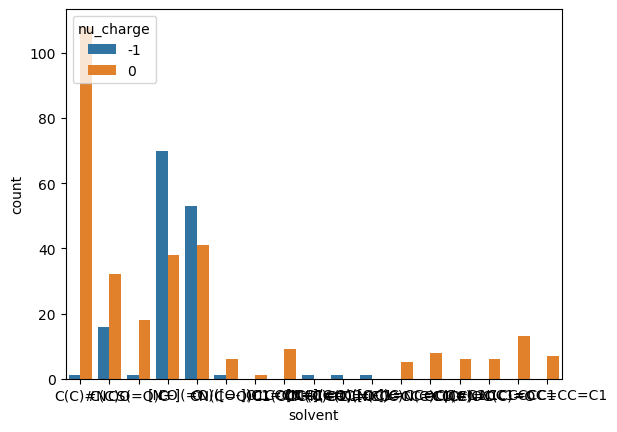

In [116]:
sns.countplot(x="solvent", hue="nu_charge", data=new_df)

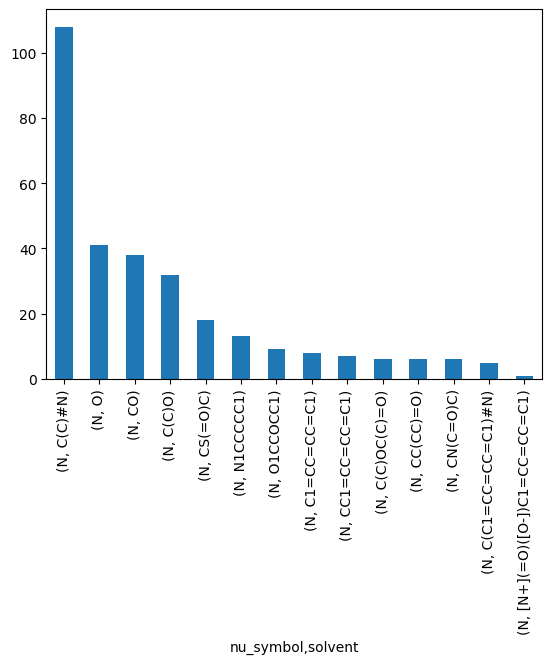

In [114]:
new_df.loc[new_df["nu_charge"] == 0].groupby("nu_symbol")["solvent"].value_counts().plot.bar()

In [72]:
new_df.groupby()["solvent"].value_counts()

nu_smiles         solvent 
C1CCNC1           C(C)#N      16
                  CS(=O)C      3
                  O            3
C1CCNCC1          C(C)#N      27
                  N1CCCCC1    13
                              ..
[S-]c1ccc(Br)cc1  C(C)O        1
[S-]c1ccc(Cl)cc1  C(C)O        1
[S-]c1cccc(Br)c1  C(C)O        1
[S-]c1cccc(Cl)c1  C(C)O        1
[S-]c1ccccc1      C(C)O        1
Name: solvent, Length: 144, dtype: int64

In [48]:
df["solvent"].

0      C(C)#N
1      C(C)#N
2      C(C)#N
3      C(C)#N
4      C(C)#N
        ...  
438    C(C)#N
439     C(C)O
440    C(C)#N
441    C(C)#N
442    C(C)#N
Name: solvent, Length: 443, dtype: object

### Set up X matrix and drop features

Save all processed data for later analysis

In [50]:
df.to_csv("train_test_data/processed_data.csv", header=True)

Drop information columns

Confirm relation between temperature and experimental barrier before dropping. Reactions with higher barriers are usually run at higher temperature.

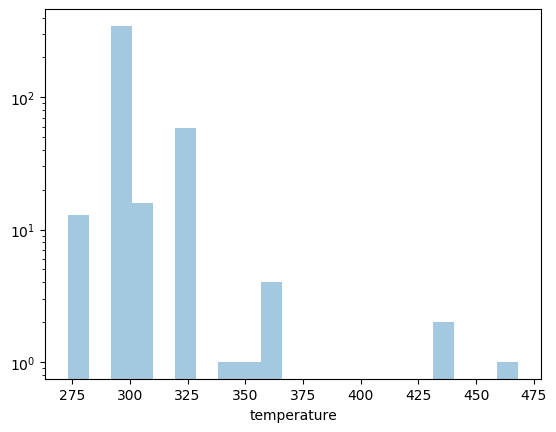

In [51]:
sns.distplot(df["temperature"], kde=False)
plt.yscale('log')

In [52]:
df["temperature"].value_counts()

298.0    288
323.0     59
293.0     58
303.0     16
273.0     13
363.0      4
432.6      1
468.4      1
432.5      1
353.0      1
344.0      1
Name: temperature, dtype: int64

Pearson R: 0.6356347947816503
Kendall tau: 0.43365100096375186
Spearman rho: 0.5404855478842033


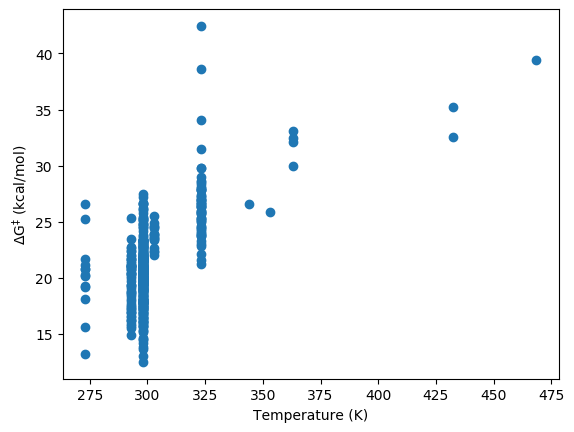

In [53]:
plt.scatter(df["temperature"], df["exp_activation_energy"])
plt.xlabel("Temperature (K)")
plt.ylabel("$\Delta$G$^\ddag$ (kcal/mol)")
print("Pearson R:", df["temperature"].corr(df["exp_activation_energy"]))
print("Kendall tau:", df["temperature"].corr(df["exp_activation_energy"], "kendall"))
print("Spearman rho:", df["temperature"].corr(df["exp_activation_energy"], "spearman"))
plt.show()

In [54]:
X = df.drop(["flat_pes", "rds", "reaction_smiles", "reaction_smiles_orig", "reaction_energy", "exp_activation_energy",
             "concerted", "solvent", "inchikey_substrate", "inchikey_nu", "inchikey_lg", "inchikey_product",
             "nu_symbol", "lg_symbol", "temperature"], axis=1)

Drop unused features

In [55]:
X.drop(["reaction_energy_qh_grimme", "reaction_energy_qh_truhlar", "p_int_area_central", "p_int_area_nu"], axis=1, inplace=True)
X.drop(["reaction_enthalpy", "activation_enthalpy"], axis=1, inplace=True)
X.drop(["sasa_central", "sasa_nu"], axis=1, inplace=True)
X.drop(["bo_diff_nu", "bo_diff_lg", "nu_formed", "lg_broken"], axis=1, inplace=True)

In [56]:
X.columns

Index(['v_av_central_atom', 'v_av_nu_atom', 'activation_energy_none',
       'activation_energy_qh_grimme_none', 'activation_energy_qh_truhlar_none',
       'sasa_ratio_nu', 'sasa_ratio_central', 'epn_central', 'epn_nu',
       'epn_lg', 'epn_central_ts', 'epn_nu_ts', 'epn_lg_ts', 'nu_charge',
       'nu_charge_ts', 'central_charge', 'central_charge_ts', 'lg_charge',
       'lg_charge_ts', 'omega', 'n', 'local_electrophilicity_center',
       'local_nucleophilicity_nu', 'is_av', 'es_av', 'p_int_central',
       'p_int_nu', 'bo_sub_lg', 'bo_nu_ts', 'bo_lg_ts', 'bo_prod_nu', 'pc_1',
       'pc_2', 'pc_3', 'pc_4', 'pc_5', 'activation_energy_nu',
       'activation_energy_qh_grimme_nu', 'activation_energy_qh_truhlar_nu',
       'activation_energy_ts', 'activation_energy_qh_grimme_ts',
       'activation_energy_qh_truhlar_ts'],
      dtype='object')

In [57]:
activation_energies_names = ['activation_energy_none',
                         'activation_energy_qh_grimme_none',
                         'activation_energy_qh_truhlar_none',
                         'activation_energy_nu',
                         'activation_energy_qh_grimme_nu',
                         'activation_energy_qh_truhlar_nu',
                         'activation_energy_ts',
                         'activation_energy_qh_grimme_ts',
                         'activation_energy_qh_truhlar_ts'
                        ]
activations_energies = X[activation_energies_names]
X.drop(activation_energies_names, axis=1, inplace=True)

In [58]:
X.columns

Index(['v_av_central_atom', 'v_av_nu_atom', 'sasa_ratio_nu',
       'sasa_ratio_central', 'epn_central', 'epn_nu', 'epn_lg',
       'epn_central_ts', 'epn_nu_ts', 'epn_lg_ts', 'nu_charge', 'nu_charge_ts',
       'central_charge', 'central_charge_ts', 'lg_charge', 'lg_charge_ts',
       'omega', 'n', 'local_electrophilicity_center',
       'local_nucleophilicity_nu', 'is_av', 'es_av', 'p_int_central',
       'p_int_nu', 'bo_sub_lg', 'bo_nu_ts', 'bo_lg_ts', 'bo_prod_nu', 'pc_1',
       'pc_2', 'pc_3', 'pc_4', 'pc_5'],
      dtype='object')

### Construct feature sets

Small

In [59]:
X_s = X.drop(["nu_charge", "nu_charge_ts", "lg_charge", "lg_charge_ts",
              'local_electrophilicity_center', 'local_nucleophilicity_nu', 'p_int_central',
              'p_int_nu', 'bo_nu_ts', 'bo_lg_ts', 'bo_sub_lg','bo_prod_nu',
              'epn_central_ts', 'epn_nu_ts', 'epn_lg_ts',
              "central_charge", "central_charge_ts", "epn_central", "epn_nu", "epn_lg", "omega", "n",
             ], axis=1)

In [60]:
X_s.columns

Index(['v_av_central_atom', 'v_av_nu_atom', 'sasa_ratio_nu',
       'sasa_ratio_central', 'is_av', 'es_av', 'pc_1', 'pc_2', 'pc_3', 'pc_4',
       'pc_5'],
      dtype='object')

No TS information

In [61]:
X_no_ts = X.drop(['epn_central_ts','nu_charge_ts', 'central_charge_ts',
              "lg_charge_ts", "bo_lg_ts", "bo_nu_ts", 'epn_nu_ts', 'epn_lg_ts'], axis=1)

In [62]:
X_no_ts.columns

Index(['v_av_central_atom', 'v_av_nu_atom', 'sasa_ratio_nu',
       'sasa_ratio_central', 'epn_central', 'epn_nu', 'epn_lg', 'nu_charge',
       'central_charge', 'lg_charge', 'omega', 'n',
       'local_electrophilicity_center', 'local_nucleophilicity_nu', 'is_av',
       'es_av', 'p_int_central', 'p_int_nu', 'bo_sub_lg', 'bo_prod_nu', 'pc_1',
       'pc_2', 'pc_3', 'pc_4', 'pc_5'],
      dtype='object')

TS information

In [63]:
X_ts = X[['epn_central_ts','nu_charge_ts', 'central_charge_ts', "lg_charge_ts", "bo_lg_ts", "bo_nu_ts", 'epn_nu_ts', 'epn_lg_ts']]

In [64]:
X_ts.columns

Index(['epn_central_ts', 'nu_charge_ts', 'central_charge_ts', 'lg_charge_ts',
       'bo_lg_ts', 'bo_nu_ts', 'epn_nu_ts', 'epn_lg_ts'],
      dtype='object')

Surface descriptors

In [65]:
X_surf = X_no_ts.drop(['epn_central', 'epn_nu', 'epn_lg', 'central_charge', 'nu_charge', 'lg_charge', 'omega', 'n',
        'local_electrophilicity_center', 'local_nucleophilicity_nu', 'bo_sub_lg', 'bo_prod_nu',
        ], axis=1)

In [66]:
X_surf.columns

Index(['v_av_central_atom', 'v_av_nu_atom', 'sasa_ratio_nu',
       'sasa_ratio_central', 'is_av', 'es_av', 'p_int_central', 'p_int_nu',
       'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5'],
      dtype='object')

Traditional descriptors

In [67]:
X_trad = X_no_ts.drop(['v_av_central_atom', 'v_av_nu_atom', 'is_av', 'es_av'], axis=1)

In [68]:
X_trad.columns

Index(['sasa_ratio_nu', 'sasa_ratio_central', 'epn_central', 'epn_nu',
       'epn_lg', 'nu_charge', 'central_charge', 'lg_charge', 'omega', 'n',
       'local_electrophilicity_center', 'local_nucleophilicity_nu',
       'p_int_central', 'p_int_nu', 'bo_sub_lg', 'bo_prod_nu', 'pc_1', 'pc_2',
       'pc_3', 'pc_4', 'pc_5'],
      dtype='object')

#### Set up y vector

In [69]:
y = df["exp_activation_energy"]

### Do train-test split

In [70]:
from sklearn.model_selection import ShuffleSplit

In [71]:
test_size = 0.2
train, test = next(ShuffleSplit(test_size=test_size, random_state=1).split(X))
np.save("train_test_data/train_indices.npy", train)
np.save("train_test_data/test_indices.npy", test)

In [72]:
activations_energies.to_csv("train_test_data/activation_energies.csv", header=True)
y.to_csv("train_test_data/y.csv", header=True)
X.to_csv("train_test_data/X.csv", header=True)
X_s.to_csv("train_test_data/X_s.csv", header=True)
X_ts.to_csv("train_test_data/X_ts.csv", header=True)
X_no_ts.to_csv("train_test_data/X_no_ts.csv", header=True)
X_surf.to_csv("train_test_data/X_surf.csv", header=True)
X_trad.to_csv("train_test_data/X_trad.csv", header=True)
X_ohe.to_csv("train_test_data/X_ohe.csv", header=True)
X_morgan_1.to_csv("train_test_data/X_morgan_1.csv", header=True)
X_morgan_2.to_csv("train_test_data/X_morgan_2.csv", header=True)
X_morgan_3.to_csv("train_test_data/X_morgan_3.csv", header=True)
X_morgan_3.to_csv("train_test_data/X_morgan_3.csv", header=True)
X_morgan_3_bit.to_csv("train_test_data/X_morgan_3_bit.csv", header=True)
X_morgan_3_512.to_csv("train_test_data/X_morgan_3_512.csv", header=True)
X_morgan_3_2048.to_csv("train_test_data/X_morgan_3_2048.csv", header=True)
X_morgan_4.to_csv("train_test_data/X_morgan_4.csv", header=True)
X_morgan_5.to_csv("train_test_data/X_morgan_5.csv", header=True)
X_morgan_6.to_csv("train_test_data/X_morgan_6.csv", header=True)
X_bert_ft.to_csv("train_test_data/X_bert_ft.csv", header=True)
X_bert_pt.to_csv("train_test_data/X_bert_pt.csv", header=True)
X_isida_seq_6.to_csv("train_test_data/X_isida_seq_6.csv", header=True)
X_isida_seq_8.to_csv("train_test_data/X_isida_seq_8.csv", header=True)
X_isida_atom_4.to_csv("train_test_data/X_isida_atom_4.csv", header=True)
X_isida_atom_8.to_csv("train_test_data/X_isida_atom_8.csv", header=True)

In [73]:
X.columns

Index(['v_av_central_atom', 'v_av_nu_atom', 'sasa_ratio_nu',
       'sasa_ratio_central', 'epn_central', 'epn_nu', 'epn_lg',
       'epn_central_ts', 'epn_nu_ts', 'epn_lg_ts', 'nu_charge', 'nu_charge_ts',
       'central_charge', 'central_charge_ts', 'lg_charge', 'lg_charge_ts',
       'omega', 'n', 'local_electrophilicity_center',
       'local_nucleophilicity_nu', 'is_av', 'es_av', 'p_int_central',
       'p_int_nu', 'bo_sub_lg', 'bo_nu_ts', 'bo_lg_ts', 'bo_prod_nu', 'pc_1',
       'pc_2', 'pc_3', 'pc_4', 'pc_5'],
      dtype='object')

# Make plots for paper

In [16]:
%config InlineBackend.figure_format = "svg"

In [17]:
plt.style.use("default")

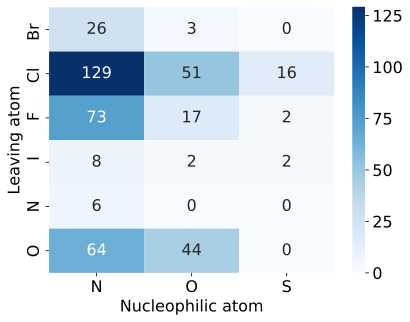

In [75]:
with matplotlib.style.context({'font.size': 16}):
    sns.heatmap(pd.crosstab(df["lg_symbol"], df["nu_symbol"]), cmap="Blues", annot=True, fmt="d")
    plt.xlabel("Nucleophilic atom")
    plt.ylabel("Leaving atom")

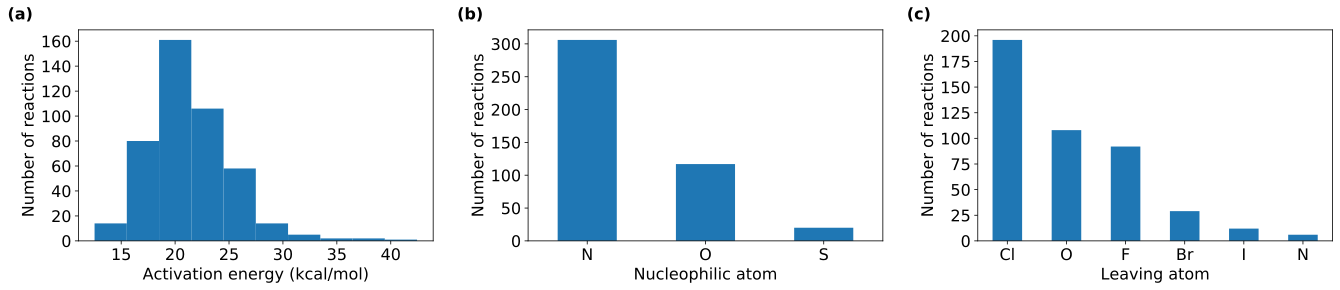

In [76]:
label_size = 16
label_placement = (-0.2, 1.05)
with matplotlib.style.context({'font.size': 16}):
    fig, ax = plt.subplots(1, 3, figsize=figsize_default * [3, 1])
    df["exp_activation_energy"].hist(grid=False, ax=ax[0])
    ax[0].set_xlabel("Activation energy (kcal/mol)")
    ax[0].set_ylabel("Number of reactions")
    ax[0].text(*label_placement, "(a)", transform=ax[0].transAxes, fontweight="bold", fontsize=label_size)
    nu_counts.plot.bar(ax=ax[1])
    ax[1].set_xlabel("Nucleophilic atom")
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)
    ax[1].set_ylabel("Number of reactions")
    ax[1].text(*label_placement, "(b)", transform=ax[1].transAxes, fontweight="bold", fontsize=label_size)
    lg_counts.plot.bar(ax=ax[2])
    ax[2].set_xlabel("Leaving atom")
    ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=0)
    ax[2].set_ylabel("Number of reactions")
    ax[2].text(*label_placement, "(c)", transform=ax[2].transAxes, fontweight="bold", fontsize=label_size)
    fig.tight_layout(pad=2)

Text(0, 0.5, 'PC2')

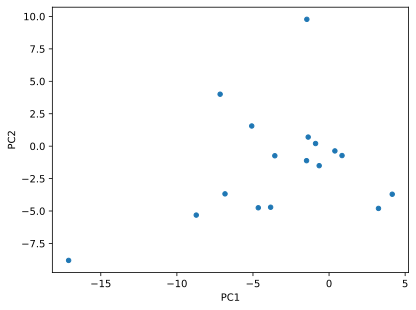

In [29]:
df.drop_duplicates("solvent")[["pc_1", "pc_2"]].plot.scatter(x="pc_1", y="pc_2")
plt.xlabel("PC1")
plt.ylabel("PC2")